In [36]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras

import Rakuten_preprocessing as rkt
from importlib import reload 
reload(rkt)

from Rakuten_preprocessing import Rakuten_img_path

## Loading the data

In [103]:
folder_path = '../data/clean/'
data = pd.read_csv(os.path.join(folder_path, 'X_train.csv'), index_col=0)
target = pd.read_csv(os.path.join(folder_path, 'Y_train.csv'), index_col=0)
prdtype = pd.read_csv('../data/prdtype.csv', index_col='prdtypecode')
target = prdtype.loc[target['prdtypecode'], 'prdtypedesignation'].reset_index()

## Function to plot results

In [57]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_classification_results(y_true, y_pred, index=None):
    #Print evaluation metrics
    print(classification_report(y_true, y_pred))
    
    #Build confusion matrix
    conf_mat = pd.crosstab(y_true, y_pred, rownames=['Classes reelles'], colnames=['Classes predites'], normalize='columns')*100

    #in case labels are encoded, update with the original lables provided
    if index is not None:
        conf_mat.index = index
        conf_mat.columns = index
        
    #hierarchical clustering to find optimal order of labels
    Z = linkage(conf_mat, 'ward')
    order = leaves_list(Z)
    conf_mat = conf_mat.iloc[order, order]

    #plot confusion matrix as heatmap
    plt.figure(figsize=(15,12))
    sns.heatmap(conf_mat, annot=round(conf_mat,2), center=50, cmap=sns.color_palette('rocket',  as_cmap=True))
    plt.show()
    
    return plt

## Dataframe for Image Generator

In [104]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#Encoding classes as integers
encoder = LabelEncoder()
labels = encoder.fit_transform(target['prdtypedesignation'])

img_paths = Rakuten_img_path(img_folder=r"C:\Users\Julien Fournier\Documents\DST\RakutenProject\Data\images\image_train_cropped",
                             imageid=data['imageid'], productid=data['productid'], suffix='')

data_img = pd.DataFrame({'labels': labels, 'img_path': img_paths})

df_train, df_test = train_test_split(data_img, test_size=0.2, random_state=123)

## Image generator

In [105]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

#Data generator for the train and test sets
train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                          rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                                          shear_range=20, horizontal_flip=True, fill_mode='constant', cval=255)

test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, fill_mode='constant', cval=255)

train_generator = train_data_generator.flow_from_dataframe(dataframe=df_train, x_col='img_path', y_col='labels',
                                                           class_mode='raw', target_size=(224, 224),
                                                           batch_size=64)

test_generator = test_data_generator.flow_from_dataframe(dataframe=df_test, x_col='img_path', y_col='labels',
                                                           class_mode='raw', shuffle=False, target_size=(224, 224),
                                                           batch_size=64)

Found 67932 validated image filenames.
Found 16984 validated image filenames.


## VGG16

In [108]:
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, Flatten
from keras.models import Sequential, Model
from keras import regularizers
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D

num_class = len(np.unique(labels))

#imagenet with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False)
#freezing VGG16 weights
for layer in base_model.layers:
    layer.trainable = False

model_vgg = Sequential()
model_vgg.add(base_model)

#adding layers for classification
model_vgg.add(GlobalAveragePooling2D()) #average over width and height, keeping channels seperate
model_vgg.add(Dense(units=128, activation='relu'))
model_vgg.add(Dropout(rate=0.2))
model_vgg.add(Dense(units=num_class, activation='softmax'))

model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_vgg.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_7  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_27 (Dense)            (None, 128)               65664     
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 27)                3483      
                                                                 
Total params: 14783835 (56.40 MB)
Trainable params: 69147 (270.11 KB)
Non-trainable params: 14714688 (56.13 MB)
_______

In [109]:
history = model_vgg.fit(x=train_generator, validation_data=test_generator, epochs=2, verbose=True)

Epoch 1/2
   4/1062 [..............................] - ETA: 20:54 - loss: 8.9104 - accuracy: 0.0352

KeyboardInterrupt: 

In [77]:
test_pred = model_vgg.predict(x=test_generator)

266/266 [==============================] - 222s 834ms/step


              precision    recall  f1-score   support

           0       0.27      0.20      0.23       341
           1       0.62      0.14      0.23       151
           2       0.73      0.90      0.80       791
           3       0.54      0.39      0.46       175
           4       0.56      0.53      0.55       176
           5       0.18      0.01      0.03       139
           6       0.48      0.55      0.51       552
           7       0.57      0.58      0.57       993
           8       0.30      0.07      0.11       415
           9       0.50      0.58      0.54      1006
          10       0.38      0.43      0.40       475
          11       0.54      0.28      0.37       298
          12       0.52      0.10      0.17       165
          13       0.37      0.37      0.37       944
          14       0.69      0.75      0.72       866
          15       0.52      0.60      0.56       979
          16       0.44      0.53      0.48       536
          17       0.36    

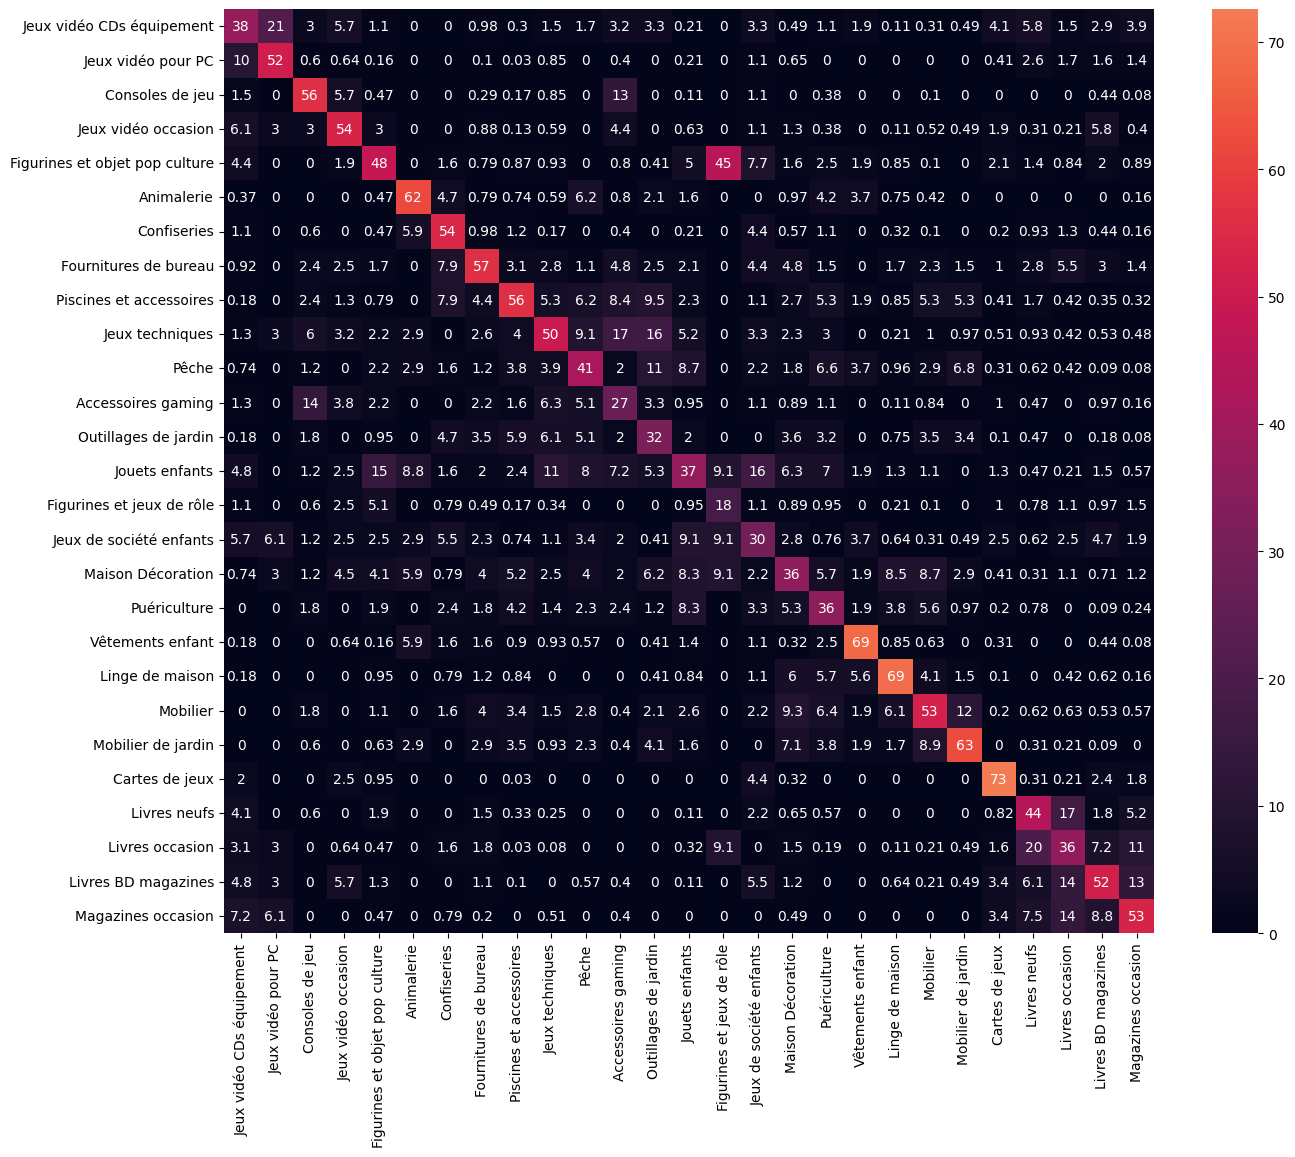

<module 'matplotlib.pyplot' from 'c:\\ProgramData\\anaconda3\\envs\\Rakuten\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [78]:
test_pred_class = np.argmax(test_pred, axis=1)
plot_classification_results(df_test['labels'], test_pred_class, index=encoder.classes_)

## ResNet50

In [111]:
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, Flatten
from keras.models import Sequential, Model
from keras import regularizers
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D

num_class = len(np.unique(labels))

#imagenet with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False)
#freezing ResNet50 weights
for layer in base_model.layers:
    layer.trainable = False

model_resnet = Sequential()
model_resnet.add(base_model)

#adding layers for classification
model_resnet.add(GlobalAveragePooling2D()) #average over width and height, (although GlobalAveragePooling2D is already in resnet50 ...?)
model_resnet.add(Dense(units=128, activation='relu'))
model_resnet.add(Dropout(rate=0.2))
model_resnet.add(Dense(units=64, activation='relu'))
model_resnet.add(Dropout(rate=0.2))
model_resnet.add(Dense(units=num_class, activation='softmax'))

model_resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_resnet.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 global_average_pooling2d_9  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_29 (Dense)            (None, 128)               262272    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 27)                3483      
                                                                 
Total params: 23853467 (90.99 MB)
Trainable params: 2

In [112]:
history = model_resnet.fit(x=train_generator, validation_data=test_generator, epochs=4)

Epoch 1/4
   3/1062 [..............................] - ETA: 16:34 - loss: 3.7402 - accuracy: 0.0521 

KeyboardInterrupt: 

266/266 [==============================] - 123s 459ms/step
              precision    recall  f1-score   support

           0       0.42      0.16      0.23       341
           1       0.56      0.28      0.38       151
           2       0.80      0.92      0.85       791
           3       0.73      0.56      0.63       175
           4       0.51      0.71      0.59       176
           5       0.73      0.14      0.23       139
           6       0.63      0.58      0.60       552
           7       0.59      0.66      0.62       993
           8       0.37      0.14      0.20       415
           9       0.56      0.70      0.62      1006
          10       0.52      0.45      0.48       475
          11       0.56      0.45      0.50       298
          12       0.52      0.39      0.45       165
          13       0.38      0.40      0.39       944
          14       0.83      0.74      0.78       866
          15       0.67      0.58      0.62       979
          16       0.4

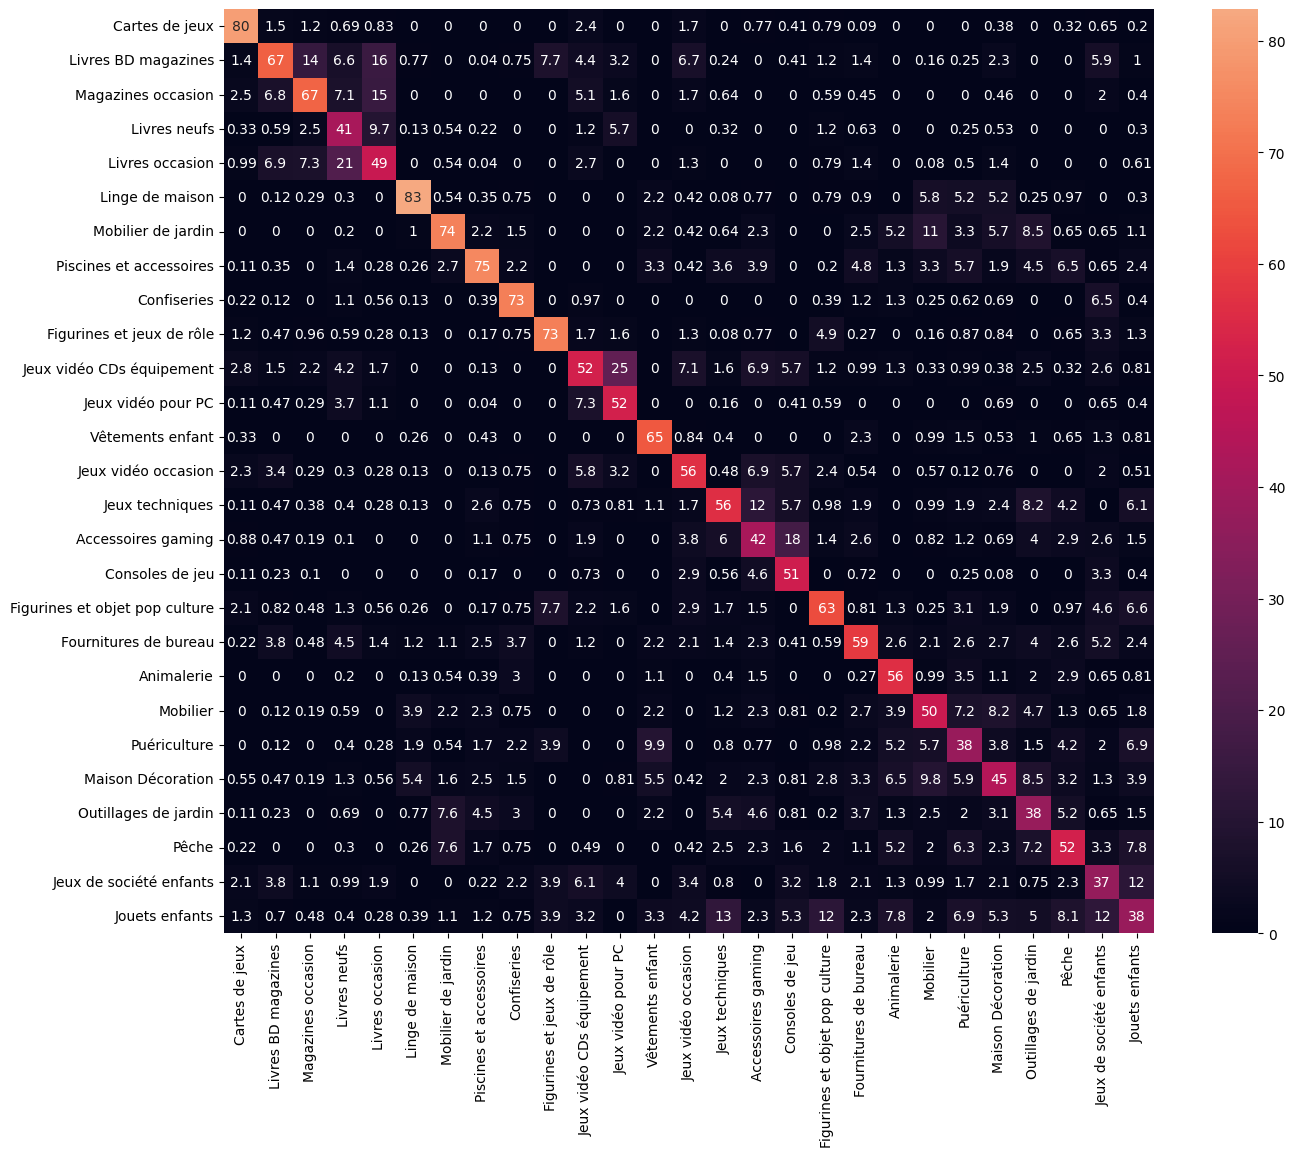

<module 'matplotlib.pyplot' from 'c:\\ProgramData\\anaconda3\\envs\\Rakuten\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [95]:
test_pred = model_resnet.predict(x=test_generator)
test_pred_class = np.argmax(test_pred, axis=1)
plot_classification_results(df_test['labels'], test_pred_class, index=encoder.classes_)

In [96]:
from sklearn.metrics import f1_score

f1_score(df_test['labels'], test_pred_class, average='weighted')

0.5654450880265625

## Customized ANN with ReseNet Blocks

In [ ]:
x = layers.Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same')(input_tensor)
x = layers.BatchNormalization()(x)
x = layers.Activation(activation)(x)
    
x = layers.Conv2D(num_filters, kernel_size=kernel_size, strides=1, padding='same')(x)
x = layers.BatchNormalization()(x)
    
    # Adding the shortcut connection
if strides > 1:
    input_tensor = layers.Conv2D(num_filters, kernel_size=1, strides=strides, padding='same')(input_tensor)
    input_tensor = layers.BatchNormalization()(input_tensor)
    
x = layers.add([x, input_tensor])
x = layers.Activation(activation)(x)